In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Configura la ruta de Google Drive donde se encuentran los datos
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/real_and_fake_face'
INITIAL_SIZE_OF_IMAGES = (128, 128)

In [ ]:
# Define transformaciones para normalizar y convertir las imágenes en tensores
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Carga los datos desde Google Drive
google_drive_path = "/content/drive/MyDrive/real_and_fake_face"
dataset = ImageFolder(root=google_drive_path, transform=transform)

In [ ]:
# Divide los datos en conjuntos de entrenamiento, validación y prueba
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Define el DataLoader para los conjuntos de entrenamiento, validación y prueba
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
# Construye el modelo CNN con Dropout y Regularización L2
class FaceClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5, weight_decay=5e-5):  # Aumenta el valor de weight_decay
        super(FaceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Instancia el modelo y muestra un resumen
model = FaceClassifier()
summary(model, (3, 224, 224))
# Define la función de pérdida y el optimizador con aumento de weight_decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)  # Aumenta el valor de weight_decay


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                  [-1, 128]      12,845,184
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 12,850,530
Trainable params: 12,850,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 49.02
Estimated Total Size (MB): 61.08
----------------------------------------------------------------


In [ ]:
# División del conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Define el DataLoader para el conjunto de entrenamiento y validación
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)


In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Establece el modelo en modo de evaluación
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Deteniendo el entrenamiento. No hay mejora en la pérdida de validación.")
                return True
        return False


In [ ]:
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, early_stopping, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Calcular la pérdida y precisión en el conjunto de validación
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Imprimir las tasas de pérdida y precisión en el conjunto de entrenamiento y validación
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_train_loss/len(train_loader)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

        # Verificar early stopping
        if early_stopping(val_loss):
            break

    # Evaluación final en el conjunto de prueba
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    print(f'Final Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%')


In [ ]:
# Configurar early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:
# Entrenamiento y evaluación del modelo con early stopping
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, early_stopping, num_epochs=10)

Epoch 1/10, Train Loss: 0.701690504184136, Validation Loss: 0.6866108008793422, Validation Accuracy: 52.81%
Epoch 2/10, Train Loss: 0.6775989601245294, Validation Loss: 0.6789612259183612, Validation Accuracy: 54.77%
Epoch 3/10, Train Loss: 0.6784093150725732, Validation Loss: 0.6913840259824481, Validation Accuracy: 52.57%
Epoch 4/10, Train Loss: 0.6625069471505972, Validation Loss: 0.6689590385981968, Validation Accuracy: 57.21%
Epoch 5/10, Train Loss: 0.6501914858818054, Validation Loss: 0.6641373549188886, Validation Accuracy: 58.92%
Epoch 6/10, Train Loss: 0.637579049055393, Validation Loss: 0.659027772290366, Validation Accuracy: 61.37%
Epoch 7/10, Train Loss: 0.6307645692275121, Validation Loss: 0.6593441452298846, Validation Accuracy: 60.39%
Epoch 8/10, Train Loss: 0.6198219129672418, Validation Loss: 0.6531017678124564, Validation Accuracy: 61.61%
Epoch 9/10, Train Loss: 0.6016395206634815, Validation Loss: 0.6695289356367928, Validation Accuracy: 60.39%
Epoch 10/10, Train Los

In [ ]:
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = images[i].cpu().numpy().transpose((1, 2, 0)) / 2 + 0.5  # Desnormalizar
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Predicted: {predicted[i]}, Actual: {labels[i]}')

    plt.show()


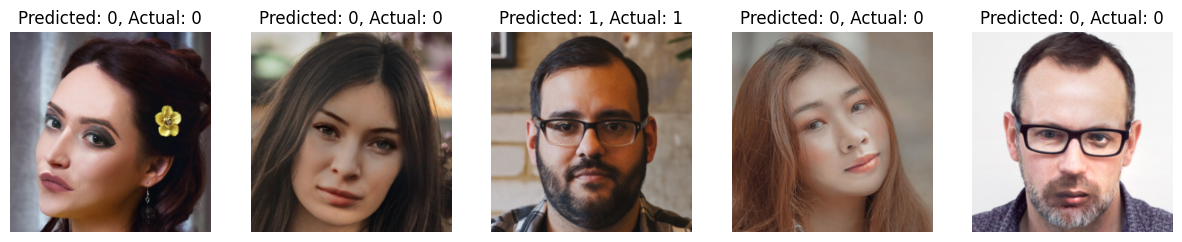

In [ ]:
visualize_predictions(model, test_loader, num_images=5)